# Uvoz tabel

In [188]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import requests

## Uvoz tehtnice

In [189]:
# getting csv files from the folder MyProject
path = "./data/"

# Get CSV files list from a folder
csv_files = glob.glob(path + "/*.csv")

# Read each CSV file into DataFrame
# This creates a list of dataframes
df_list = (pd.read_csv(file, header=None) for file in csv_files)

# Concatenate all DataFrames
panji_vsi   = pd.concat(df_list, ignore_index=True)

panj_en_dan = pd.read_csv(r'./data/Hive_1.csv', header=None)
panj_en_dan.columns =['meritev', 'teza']

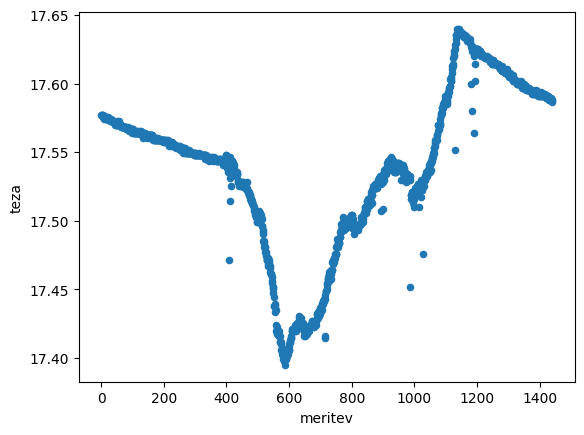

In [190]:
panj_en_dan.plot(kind = 'scatter', x = "meritev", y = "teza")

plt.show()

## Uvoz vremena

#### En dan (direktno parsanje s spleta)

In [191]:
url = 'https://www.si-vreme.com/si/slovenija/vreme/avtomatske-postaje?xs=si-avt_vremenski_podatki&xt=2&ts=0&tl1=LJUBL-ANA_BEZIGRAD_&tl2=LJUBL-ANA_BRNIK_&gm=0&gh=3&go=1&gg=2&gv=9&gd=tml&gc=_vlaznost_smer-vetra_hitrost-v_sunki-v_tlak_padavine_sonce_tempTal005_tempTal010_tempTal020_tempTal030_tempTal050&gu=1&gp=4&fo=0#vsebina'
html = requests.get(url).content
df_list = pd.read_html(html)
df = df_list[-1]
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,kraj 1,št.,kraj,temp. zraka [°C],vlaga [%],smer vetra [°],hitrost vetra [Km/h],sunki vetra [Km/h],tlak [hPa],padavine [mm],sonce [W/m2],temp. tal 5cm [°C],temp. tal 10cm [°C],temp. tal 20cm [°C],temp. tal 30cm [°C],temp. tal 50cm [°C],kraj 2
1,>,1,Babno Polje,23.7,43,-,-,-,-,0.0,-,-,-,-,-,-,<
2,>,2,Bilje Nova Gorica,28.0,39,226,12,26,1012,0.0,759,34.5,31.4,28.3,26.4,25.4,<
3,>,3,Blegoš,18.2,63,-,-,-,-,0.0,-,-,-,-,-,-,<
4,>,4,Bohinjska Češnjica,26.2,43,-,-,-,-,0.0,-,-,-,-,-,-,<


#### Dnevno

Zaenkrat alfa pristop s kopiranjem arso html-ja. V prihodnosti s *selenium* knjižnico

In [192]:
vreme_dnevno = pd.read_csv(r'./data/vreme_teden.txt')

In [193]:
vreme_dnevno.head()

,dan,povp. dnevna T [°C],količina padavin [mm],višina snežne odeje [cm],nevihta,toča,viharni veter
0,2023-06-05,16.2,5.2,0,ne,ne,ne
1,2023-06-06,18.2,20.7,0,ne,ne,ne
2,2023-06-07,19.6,5.2,0,da,ne,ne
3,2023-06-08,17.3,0.0,0,da,da,ne
4,2023-06-09,20.2,15.7,0,da,ne,ne


## Združevanje

## Odstranjevanje čudnih vrednosti (koda še ni testirana)

### Globalno (ogromni oulierji, ki niso vezani nujno na potek npr. mačka skoči na panj, čebelar odmakne panj, ...)

In [194]:
def replace_outliers_with_average_global(df, column_name, threshold=3):
    # Copy the DataFrame to avoid modifying the original data
    cleaned_df = df.copy()
    
    # Calculate the mean and standard deviation of the column
    mean = cleaned_df[column_name].mean()
    std = cleaned_df[column_name].std()
    
    # Calculate the Z-scores for each data point
    z_scores = np.abs((cleaned_df[column_name] - mean) / std)
    
    # Identify the outliers based on the threshold
    outliers = z_scores > threshold
    
    # Replace the outliers with the average of the previous and next value
    previous_values = cleaned_df[column_name].shift(1)
    next_values = cleaned_df[column_name].shift(-1)
    cleaned_df.loc[outliers, column_name] = (previous_values[outliers] + next_values[outliers]) / 2
    
    return cleaned_df

In [195]:
panj_en_dan = replace_outliers_with_average_global(panj_en_dan, "teza", threshold=1)

### Lokalno (male spremembe vrednosti (ki so lahko npr. še vedno blizu meritev, a ne sovpadajo z regresijo) npr. napaka tehtnice ipd.)

In [196]:
def replace_outliers_lof(df, column_name, window_size=1, contamination=0.1):
    # Copy the DataFrame to avoid modifying the original data
    cleaned_df = df.copy()
    
    # Fit the Local Outlier Factor model
    lof = LocalOutlierFactor(contamination=contamination)
    outliers = lof.fit_predict(cleaned_df[[column_name]])
    
    # Replace the outliers with the average of previous and next values
    for i, val in enumerate(cleaned_df[column_name]):
        if outliers[i] == -1:
            start_index = max(i - window_size, 0)
            end_index = min(i + window_size + 1, len(cleaned_df))
            avg = cleaned_df.iloc[start_index:end_index][column_name].mean()
            cleaned_df.at[i, column_name] = avg
    
    return cleaned_df

In [197]:
panj_en_dan = replace_outliers_lof(panj_en_dan, 'teza', window_size=1, contamination=0.5)

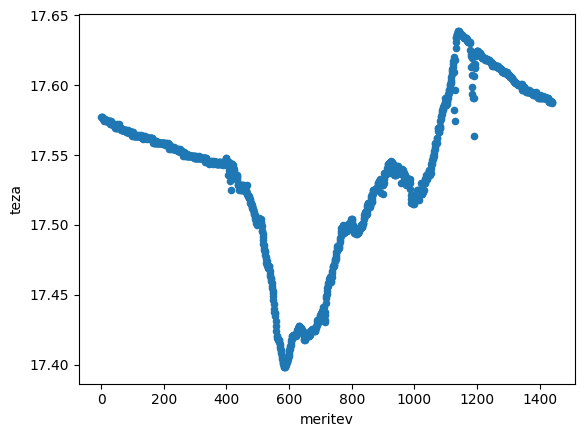

In [198]:
panj_en_dan.plot(kind = 'scatter', x = "meritev", y = "teza")

plt.show()